In [ ]:
### Purpose: Plot gene length - Figure S5D
### Input: annotation.gtf, outputs from scripts 1 and 3

In [22]:
import pandas as pd
import gffutils
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import mannwhitneyu



In [9]:
df = pd.read_csv('whippet_CE_gene_name_exon_number.csv')
gtf_file='gencode.v44.basic.annotation.gtf'

In [10]:
# # Create a database from the GTF file
db = gffutils.create_db(gtf_file, dbfn=db_file, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

In [11]:
# # Load the GFF/GTF database
# db_file = 'gencode.v44.basic.annotation.db'  
# db = gffutils.FeatureDB(db_file)

In [12]:
# Compute gene lengths for all unique gene IDs
gene_lengths = {gene_id: db[gene_id].end - db[gene_id].start + 1 for gene_id in df['Gene'].unique()}

# Map gene lengths to the DataFrame
df['gene_length'] = df['Gene'].map(gene_lengths).astype(int)


In [14]:
df.to_csv('whippet_CE_gene_length.csv')

In [15]:
#### LOAD OTHER NECESSARY DATAFRAMES 
blocks= pd.read_csv('block_exons_ddPSImax0.2_adjacent.csv')
single= pd.read_csv('other_regulated_exons.csv')
sig_whip = pd.read_csv('sig_whip_CE_prob0.9_dPSI0.1.csv')


In [16]:
gl_non_reg = df[~df['Coord'].isin(sig_whip['Coord'])].copy()

In [17]:
gl_blocks = df[df['Coord'].isin(blocks['Coord'])].copy()
gl_single = df[df['Coord'].isin(single['Coord'])].copy()

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_31365/3059931374.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


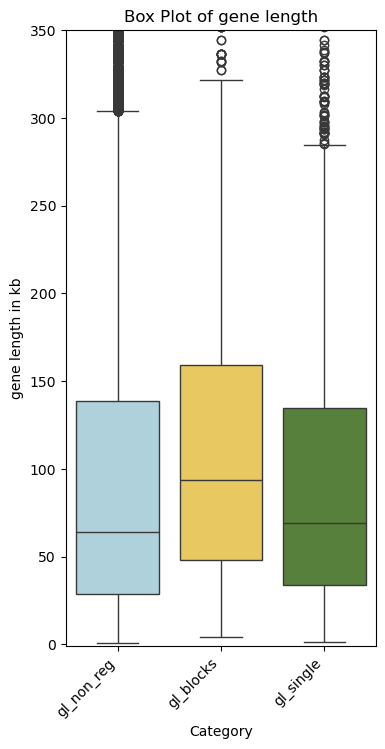

In [20]:
#### PLOT GENE LENGTH #####

# Define the custom color mapping
custom_colors = {
    "gl_blocks": "#FFD449",  # Yellow
    "gl_single": "#548C2F",  # Green
    "gl_non_reg": "#A8D5E2",  # Blue
}

# Create a dictionary to store the gene_length dataframes
gl_dataframes = {
    "gl_non_reg": gl_non_reg,
    "gl_blocks": gl_blocks,
    "gl_single":gl_single
}

# Create a list to store the data for plotting
plot_data = []

# Populate the plot_data list
for name, df in gl_dataframes.items():
    if "gene_length" in df.columns:
        for value in df["gene_length"]:
            plot_data.append({"Category": name, "gene_length": value})

# Convert the list to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Convert gene_length to kb
plot_df['gene_length_kb'] = plot_df['gene_length'] / 1000

# Create the box plot
plt.figure(figsize=(4, 8))
sns.boxplot(
    x="Category",
    y="gene_length_kb",
    data=plot_df,
    palette=[custom_colors[cat] for cat in plot_df["Category"].unique()]
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Add title and labels
plt.title("Box Plot of gene length")
plt.ylim(-1,350)
plt.xlabel("Category")
plt.ylabel("gene length in kb")

plt.savefig('gene_length.pdf')

# Show the plot
plt.show()

In [23]:
# Extract gene length values for each category
gene_length_values = {
    name: df["gene_length"].dropna().values  # Drop NaN values if any
    for name, df in gl_dataframes.items()
    if "gene_length" in df.columns
}

# List to store results
p_values = []

# Perform Mann-Whitney U test for each pair of categories
comparisons = list(combinations(gene_length_values.keys(), 2))  # List of all category pairs
num_tests = len(comparisons)  # Number of tests for Bonferroni correction

for (cat1, cat2) in comparisons:
    data1 = gene_length_values[cat1]
    data2 = gene_length_values[cat2]

    if len(data1) > 0 and len(data2) > 0:  # Ensure both categories have data
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

        # Apply Bonferroni correction
        p_corrected = min(p * num_tests, 1.0)  # Ensure p-value does not exceed 1

        p_values.append({
            "Category 1": cat1, 
            "Category 2": cat2, 
            "Raw p-value": p, 
            "Bonferroni-corrected p-value": p_corrected
        })

# Convert results into a DataFrame
p_values_df = pd.DataFrame(p_values)

# Print the results
print(p_values_df)




   Category 1 Category 2   Raw p-value  Bonferroni-corrected p-value
0  gl_non_reg  gl_blocks  1.126057e-64                  3.378172e-64
1  gl_non_reg  gl_single  4.473413e-04                  1.342024e-03
2   gl_blocks  gl_single  2.336605e-28                  7.009814e-28
